## Experiment
As SPY ETF holdings changes over time. So we build a simple strategy around that. Portfolio goes long stocks added to the index and shorts equivalent amount of stocks deleted. To keep this notebook simple we only traded following stocks `PENN`, `PVH`, `INVH`, `CSGP`.
We test short-term holding period such as entry_point `2022-09-02`, exit_point `2022-10-31`. However this experiment can be extended as backtesting libraries like `vectorbt`, `backtrader`,`alpaca-py`, `pyfolio` are all baked into this docker image so that customers don't have to spend time figuring out dependency management.

ETF holding changes are as follows:
**announcement date:**  2022-09-02
**effective date:** 2022-09-19

### Data Preparation

In this section we are going to prepare dataset using data provider's API. First we'll download the SPY ETF holdings for Q1 2022. We'll tag this data as 2022Q1 to be able to access state of the table later on easily. The next update from data provider api is on Q3 2022 therefore first we'll expire the stocks in the etf holdings table and merge new stocks into it. If stocks are matching then we'll set the status as `unchanged` to state that stock is still part of etf. If there are additional stocks in the new dataset then we'll set the status as `new`. If new dataset is lacking some stocks that existing etf_holdings table has then we'll leave these stocks status as `expired` to state that these stocks are no longer in the etf. Each state transition will be tagged for trackability purpose.

In [ ]:
import requests
import json
from pyspark.sql import functions as f

API_KEY='{YOUR API KEY}'

def url_for_etf_holdings(date):
    return f'https://url/to/dataendpoint'


def load_json_as_dataframe(url, selector=None):    
    data = requests.get(url).content.decode('utf-8')
    json_data = json.loads(data)
    rdd = spark.sparkContext.parallelize(json_data[selector] if selector else json_data)
    return spark.read.json(rdd)

(
    load_json_as_dataframe(url_for_etf_holdings('2022-03-31'))
    .withColumn("status",f.lit("new"))
    .createOrReplaceTempView("2022Q1")
)

In [ ]:
spark.sql("DROP TABLE IF EXISTS glue_catalog.quant.etf_holdings")
spark.sql("""
CREATE TABLE glue_catalog.quant.etf_holdings
USING iceberg
OPTIONS ('format-version'='2')
LOCATION 's3://trader-warehouse-us-east-1/etf_holdings/'
AS SELECT * FROM 2022Q1
""")

In [5]:
# Quick look at the table if we have the data
spark.table("glue_catalog.quant.etf_holdings").select("symbol","date","acceptanceTime", "status").show()

+------+----------+-------------------+------+
|symbol|      date|     acceptanceTime|status|
+------+----------+-------------------+------+
|   HON|2022-03-31|2022-05-27 13:54:03|   new|
|   DFS|2022-03-31|2022-05-27 13:54:03|   new|
|   FMC|2022-03-31|2022-05-27 13:54:03|   new|
|  NDSN|2022-03-31|2022-05-27 13:54:03|   new|
|   CRL|2022-03-31|2022-05-27 13:54:03|   new|
|  EPAM|2022-03-31|2022-05-27 13:54:03|   new|
|  CSCO|2022-03-31|2022-05-27 13:54:03|   new|
|   ALB|2022-03-31|2022-05-27 13:54:03|   new|
|   AIZ|2022-03-31|2022-05-27 13:54:03|   new|
|   CRM|2022-03-31|2022-05-27 13:54:03|   new|
|  PENN|2022-03-31|2022-05-27 13:54:03|   new|
|  INTU|2022-03-31|2022-05-27 13:54:03|   new|
|   DOW|2022-03-31|2022-05-27 13:54:03|   new|
|   LHX|2022-03-31|2022-05-27 13:54:03|   new|
|   BLK|2022-03-31|2022-05-27 13:54:03|   new|
|  ZBRA|2022-03-31|2022-05-27 13:54:03|   new|
|   UPS|2022-03-31|2022-05-27 13:54:03|   new|
|    DG|2022-03-31|2022-05-27 13:54:03|   new|
|  DISH|2022-

#### Labeling Table

Here we are going to label this initial table so that later on we can access the state of the table as it was later on.

In [6]:
spark.sql("ALTER TABLE glue_catalog.quant.etf_holdings CREATE TAG Q1_2022")

DataFrame[]

### Simulate a Scenario of ETF Holdings Table Ingestion
In this step we'll expire etf holdings first then merge new ones into it. If we already have the stock in the existing table then we'll set status back to unchanged. If there are new stocks they'll be registered as new. Non matching stocks will stay expired. That way in this table we'll be able keep both new, unchanged and expired stocks in the etf holdings table. 

In [7]:
spark.sql("""
UPDATE glue_catalog.quant.etf_holdings
SET status = 'expired'
""")

DataFrame[]

In [8]:
spark.table("glue_catalog.quant.etf_holdings").select("symbol","date","acceptanceTime", "status").show()

+------+----------+-------------------+-------+
|symbol|      date|     acceptanceTime| status|
+------+----------+-------------------+-------+
|   HON|2022-03-31|2022-05-27 13:54:03|expired|
|   DFS|2022-03-31|2022-05-27 13:54:03|expired|
|   FMC|2022-03-31|2022-05-27 13:54:03|expired|
|  NDSN|2022-03-31|2022-05-27 13:54:03|expired|
|   CRL|2022-03-31|2022-05-27 13:54:03|expired|
|  EPAM|2022-03-31|2022-05-27 13:54:03|expired|
|  CSCO|2022-03-31|2022-05-27 13:54:03|expired|
|   ALB|2022-03-31|2022-05-27 13:54:03|expired|
|   AIZ|2022-03-31|2022-05-27 13:54:03|expired|
|   CRM|2022-03-31|2022-05-27 13:54:03|expired|
|  PENN|2022-03-31|2022-05-27 13:54:03|expired|
|  INTU|2022-03-31|2022-05-27 13:54:03|expired|
|   DOW|2022-03-31|2022-05-27 13:54:03|expired|
|   LHX|2022-03-31|2022-05-27 13:54:03|expired|
|   BLK|2022-03-31|2022-05-27 13:54:03|expired|
|  ZBRA|2022-03-31|2022-05-27 13:54:03|expired|
|   UPS|2022-03-31|2022-05-27 13:54:03|expired|
|    DG|2022-03-31|2022-05-27 13:54:03|e

Now entire table is in expired state. However we can still query the table in the previous state using tags. So that quants won't be effected from ongoing maintanence task

In [9]:
spark.sql("""SELECT symbol, date, acceptanceTime, status 
FROM glue_catalog.quant.etf_holdings 
VERSION AS OF 'Q1_2022'
""").show()

+------+----------+-------------------+------+
|symbol|      date|     acceptanceTime|status|
+------+----------+-------------------+------+
|   HON|2022-03-31|2022-05-27 13:54:03|   new|
|   DFS|2022-03-31|2022-05-27 13:54:03|   new|
|   FMC|2022-03-31|2022-05-27 13:54:03|   new|
|  NDSN|2022-03-31|2022-05-27 13:54:03|   new|
|   CRL|2022-03-31|2022-05-27 13:54:03|   new|
|  EPAM|2022-03-31|2022-05-27 13:54:03|   new|
|  CSCO|2022-03-31|2022-05-27 13:54:03|   new|
|   ALB|2022-03-31|2022-05-27 13:54:03|   new|
|   AIZ|2022-03-31|2022-05-27 13:54:03|   new|
|   CRM|2022-03-31|2022-05-27 13:54:03|   new|
|  PENN|2022-03-31|2022-05-27 13:54:03|   new|
|  INTU|2022-03-31|2022-05-27 13:54:03|   new|
|   DOW|2022-03-31|2022-05-27 13:54:03|   new|
|   LHX|2022-03-31|2022-05-27 13:54:03|   new|
|   BLK|2022-03-31|2022-05-27 13:54:03|   new|
|  ZBRA|2022-03-31|2022-05-27 13:54:03|   new|
|   UPS|2022-03-31|2022-05-27 13:54:03|   new|
|    DG|2022-03-31|2022-05-27 13:54:03|   new|
|  DISH|2022-

So while quants are busy with working on this branch of the data ongoing ETL process is now going to update the data with new ETF holdings data.

In [10]:
(
    load_json_as_dataframe(url_for_etf_holdings('2022-09-30'))
    .withColumn("status",f.lit("new"))
    .createOrReplaceTempView("2022Q3")
)

spark.sql("""
MERGE INTO glue_catalog.quant.etf_holdings t
USING (SELECT * FROM 2022Q3) s
ON t.isin = s.isin
WHEN MATCHED THEN
    UPDATE SET t.acceptanceTime = s.acceptanceTime,
               t.date = s.date,
               t.balance = s.balance,
               t.valUsd = s.valUsd,
               t.pctVal = s.pctVal,
               t.status = "unchanged"
WHEN NOT MATCHED THEN INSERT *
""")

DataFrame[]

Since now we merged new data into our existing table it's time to tag this as well

In [11]:
spark.sql("ALTER TABLE glue_catalog.quant.etf_holdings CREATE TAG Q3_2022")

DataFrame[]

Let's query the newly added and expired stocks to see the effect of rebalance on the ETF

In [12]:
spark.sql("""SELECT symbol, isin, acceptanceTime, date 
FROM glue_catalog.quant.etf_holdings 
AS OF 'Q3_2022' EXCEPT 
SELECT symbol, isin, acceptanceTime, date 
FROM glue_catalog.quant.etf_holdings 
AS OF 'Q1_2022'
""").show()


+------+------------+-------------------+----------+
|symbol|        isin|     acceptanceTime|      date|
+------+------------+-------------------+----------+
|   CPT|US1331311027|2022-11-28 15:50:55|2022-09-30|
|  CSGP|US22160N1090|2022-11-28 15:50:55|2022-09-30|
|  EMBC|US29082K1051|2022-11-28 15:50:55|2022-09-30|
|  INVH|US46187W1071|2022-11-28 15:50:55|2022-09-30|
|     J|US46982L1089|2022-11-28 15:50:55|2022-09-30|
|   KDP|US49271V1008|2022-11-28 15:50:55|2022-09-30|
|    ON|US6821891057|2022-11-28 15:50:55|2022-09-30|
|  VICI|US9256521090|2022-11-28 15:50:55|2022-09-30|
|   WBD|US9344231041|2022-11-28 15:50:55|2022-09-30|
+------+------------+-------------------+----------+



Also let's query expired stocks to see which ones are removed from the ETF

In [13]:
spark.sql("""SELECT symbol, isin, acceptanceTime, date 
FROM glue_catalog.quant.etf_holdings 
AS OF 'Q1_2022' EXCEPT 
SELECT symbol, isin, acceptanceTime, date 
FROM glue_catalog.quant.etf_holdings 
AS OF 'Q3_2022'
""").show()

+------+------------+-------------------+----------+
|symbol|        isin|     acceptanceTime|      date|
+------+------------+-------------------+----------+
|  PENN|US7075691094|2022-05-27 13:54:03|2022-03-31|
|    UA|US9043112062|2022-05-27 13:54:03|2022-03-31|
|   UAA|US9043111072|2022-05-27 13:54:03|2022-03-31|
|   LTP|US7127041058|2022-05-27 13:54:03|2022-03-31|
| DISCA|US25470F1049|2022-05-27 13:54:03|2022-03-31|
|  CERN|US1567821046|2022-05-27 13:54:03|2022-03-31|
|  IPGP|US44980X1090|2022-05-27 13:54:03|2022-03-31|
|      |US25470F3029|2022-05-27 13:54:03|2022-03-31|
|     J|US4698141078|2022-05-27 13:54:03|2022-03-31|
|   PVH|US6936561009|2022-05-27 13:54:03|2022-03-31|
+------+------------+-------------------+----------+



### Backtesting
In this section we'll backtest the strategy that about is taking long position for stocks that are added to ETF such as `CSGP` and `INVH` and taking short position that are removed from the index such as `PVH` and `PENN`. First we'll examine this strategy on the chart to see if divergence really happened. To do that we need historical data for CSGP, INVH, PVH and PENN as well as SPY to see how ETF behaved overtime.

In [18]:
symbols = ["CSGP", "INVH", "PVH", "PENN"]

def url_for_historical_data(symbol, date_from, date_to):
    return f'https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={date_from}&to={date_to}&apikey={API_KEY}'


def historical_data_for(symbol, columns=["open", "high", "low", "close", "adjClose"]):
    cols = [f.col(c).alias(f"{symbol}_{c}") for c in columns]
    cols.insert(0, "date") 
    return (
        load_json_as_dataframe(
            url_for_historical_data(symbol, "2022-08-01", "2022-12-01"), 
            "historical"
        )
        .select(cols)
    )

spark.sql("DROP TABLE IF EXISTS glue_catalog.quant.historical_prices")

(
    historical_data_for("SPY",["open","close"])
        .orderBy("date")
        .writeTo("glue_catalog.quant.historical_prices")
        .using("iceberg")
        .createOrReplace()
)

for symbol in symbols:
    (
        historical_data_for(symbol,["open","close"]).join(
            spark.table("glue_catalog.quant.historical_prices"), 
            on = "date", 
            how = "left")
        .orderBy("date")
        .writeTo("quant.historical_prices")
        .using("iceberg")
        .createOrReplace()
    )

In [32]:
historical_prices = spark.table("glue_catalog.quant.historical_prices")

def select_columns(df, ohlcv):
    columns = [cols for cols in df.columns if ohlcv in cols]
    df_prices = df[columns]
    df_prices.rename(columns={c:c.replace(f"_{ohlcv}","") for c in columns}, inplace=True)
    return df_prices


historical_prices_pd = historical_prices.drop("SPY_open","SPY_close").toPandas()
historical_prices_pd['date'] = pd.to_datetime(historical_prices_pd['date'])
historical_prices_pd.set_index("date", inplace=True)

historical_open_prices = select_columns(historical_prices_pd, "open")
historical_close_prices = select_columns(historical_prices_pd, "close")

historical_prices.show()

+----------+---------+----------+--------+---------+---------+----------+---------+----------+--------+---------+
|      date|PENN_open|PENN_close|PVH_open|PVH_close|INVH_open|INVH_close|CSGP_open|CSGP_close|SPY_open|SPY_close|
+----------+---------+----------+--------+---------+---------+----------+---------+----------+--------+---------+
|2022-08-01|    33.94|     34.53|   61.61|    62.23|    38.96|     38.51|    71.92|     71.16|  409.15|   410.77|
|2022-08-02|    34.09|     36.17|   61.32|     61.2|    38.48|     37.98|    70.59|     70.99|  409.12|   408.06|
|2022-08-03|    36.91|     36.59|   62.14|    63.03|    38.11|     37.67|    71.31|     72.52|   410.3|   414.45|
|2022-08-04|     36.0|     35.14|   62.92|    63.73|    37.67|     37.92|    72.69|     72.87|  414.37|   414.17|
|2022-08-05|     34.2|     34.15|   63.19|    64.38|    37.68|     37.88|    71.66|     72.87|  409.66|   413.47|
|2022-08-08|    34.76|     36.05|   65.51|    66.36|    37.98|     37.92|    72.95|     

/tmp/ipykernel_68/2722982548.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices.rename(columns={c:c.replace(f"_{ohlcv}","") for c in columns}, inplace=True)
/tmp/ipykernel_68/2722982548.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices.rename(columns={c:c.replace(f"_{ohlcv}","") for c in columns}, inplace=True)


We have daily open and close prices for the assets we mentioned about. In the following section we'll calculate daily returns of each one of these stocks based on their daily close price difference. And show cumulative return on one chart to see how they diverge/converge from each other

<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_68/4001668177.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  color = "green" if col in stocks_added else "blue" if col is "SPY" else "red"


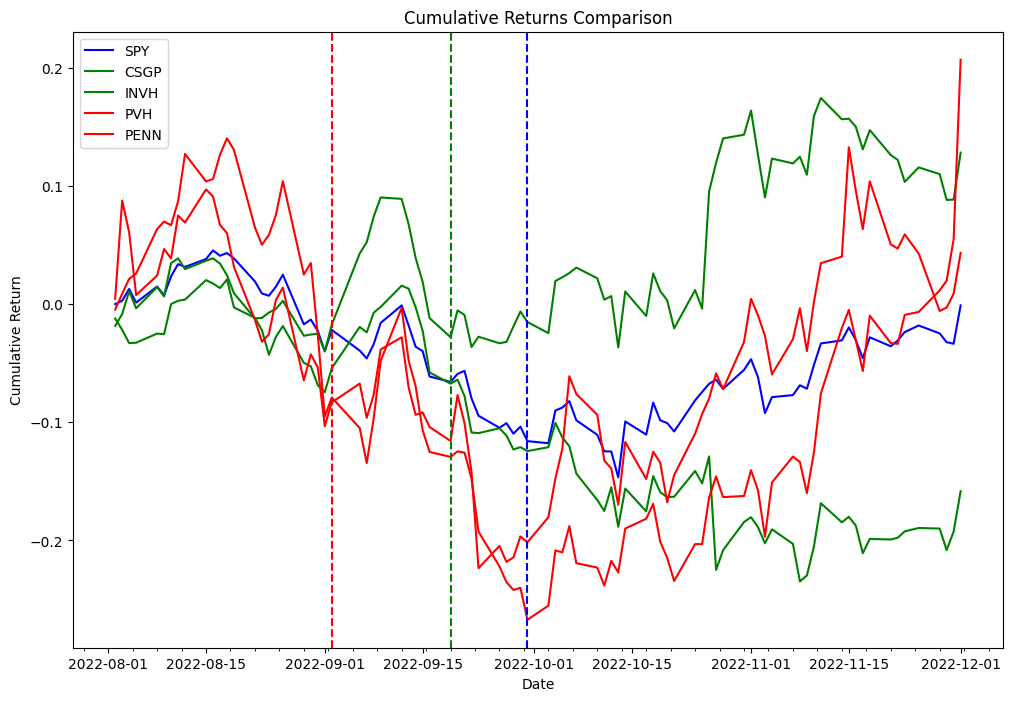

In [22]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

plt.style.use('default')


def formula_for_stock_return(symbol):
    return f"round(({symbol}_open - LAG({symbol}_open, 1) OVER (ORDER BY date)) / LAG({symbol}_open, 1) OVER (ORDER BY date), 4) AS {symbol}_daily_return"

stocks = ["SPY"] + symbols
returns_df = spark.sql(f"""
SELECT date,  
       {",".join([formula_for_stock_return(stock) for stock in stocks])},
       {",".join(f"{stock}_open,{stock}_close" for stock in stocks)}
FROM glue_catalog.quant.historical_prices
ORDER BY date
""").toPandas()
returns_df['date'] = pd.to_datetime(returns_df['date'])
returns_df.set_index("date", inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
stocks_added={"CSGP", "INVH"}

for col in stocks:
    c = f"{col}_daily_return"
    cum_returns = (1 + returns_df[c]).cumprod() - 1
    color = "green" if col in stocks_added else "blue" if col is "SPY" else "red"
    ax.plot(returns_df.index, cum_returns, label=col, color=color)


ax.set_title("Cumulative Returns Comparison")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.axvline(pd.Timestamp('2022-09-02'), color='r', linestyle='--')
ax.axvline(pd.Timestamp('2022-09-19'), color='g', linestyle='--')
ax.axvline(pd.Timestamp('2022-09-30'), color='b', linestyle='--')

plt.legend()
plt.show()


As we can see in the graph actual divergence starts at the beginning of the September. However in the data we have date column as end of September. Then quant realizes here that data might be broken somehow. Luckily with Apache Iceberg we can go back in time and query the table based on tags. That will allow quants to see what was the state of the table at given point of time.

Let's backtest the following strategy for different position openning times. Here we'll long stocks added to the index and shorts equivalent amount of stocks removed from the index. We test short-term holding periods, such as 1 day and 1/2/3/4 weeks, as we assume that rebalancing effect is very short lived and new information, such as macro-economics, will drive performance beyond studied time horizons. Lastly we simulate different entry points for this trade 
- market open the day after announcement day (AD+1) 
- market close of effective date (ED0) 
- market open the day after ETF holdings registered the change (MD+1).

In [65]:
import numpy as np
import vectorbt as vbt

def backtest(entry_point='2022-09-02', exit_point='2022-10-31'):
    open_position = (historical_prices_pd.index == entry_point)
    close_position = (historical_prices_pd.index == exit_point)

    CASH = 100000
    COMMPERC = 0.000

    symbol_cols = pd.Index(['PENN', 'PVH', 'INVH', 'CSGP'], name='symbol')
    order_size = pd.DataFrame(index=historical_prices_pd.index, columns=symbol_cols)
    order_size['PENN'] = np.nan
    order_size['PVH'] = np.nan
    order_size['INVH'] = np.nan
    order_size['CSGP'] = np.nan

    #short
    order_size.loc[open_position, 'PENN'] = -10
    order_size.loc[close_position, 'PENN'] = 0

    order_size.loc[open_position, 'PVH'] = -10
    order_size.loc[close_position, 'PVH'] = 0

    #long
    order_size.loc[open_position, 'INVH'] = 10
    order_size.loc[close_position, 'INVH'] = 0

    order_size.loc[open_position, 'CSGP'] = 10
    order_size.loc[close_position, 'CSGP'] = 0

    # Execute at the next bar
    order_size = order_size.vbt.fshift(1)

    portfolio = vbt.Portfolio.from_orders(
            historical_close_prices,  # current close as reference price
            size=order_size,  
            price=historical_open_prices,  # current open as execution price
            size_type='targetpercent', 
            val_price=historical_close_prices.vbt.fshift(1),  # previous close as group valuation price
            init_cash=CASH,
            allow_partial=False,
            fees=COMMPERC,
            direction='both',
            cash_sharing=True,  # share capital between assets in the same group
            group_by=True,  # all columns belong to the same group
            call_seq='auto',  # sell before buying
            freq='d'  # index frequency for annualization
    )
    return portfolio

In [75]:
portfolio = backtest('2022-09-02', '2022-10-31')

In [76]:
portfolio.orders.records_readable.head(20)

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,"(PENN, PENN)",2022-09-06,31948.881789,31.66,0.0,Sell
1,1,"(PVH, PVH)",2022-09-06,18321.729571,55.15,0.0,Sell
2,2,"(INVH, INVH)",2022-09-06,27419.797094,38.20,0.0,Buy
3,3,"(CSGP, CSGP)",2022-09-06,14106.361969,75.00,0.0,Buy
4,4,"(CSGP, CSGP)",2022-11-01,14106.361969,83.70,0.0,Sell
5,5,"(INVH, INVH)",2022-11-01,27419.797094,31.94,0.0,Sell
6,6,"(PVH, PVH)",2022-11-01,18321.729571,52.95,0.0,Buy
7,7,"(PENN, PENN)",2022-11-01,31948.881789,34.09,0.0,Buy


In [77]:
portfolio.cash().rename('cash')

date
2022-08-01    100000.000000
2022-08-02    100000.000000
2022-08-03    100000.000000
2022-08-04    100000.000000
2022-08-05    100000.000000
                  ...      
2022-11-25     13749.441636
2022-11-28     13749.441636
2022-11-29     13749.441636
2022-11-30     13749.441636
2022-12-01     13749.441636
Name: cash, Length: 87, dtype: float64

In [80]:
portfolio2 = backtest('2022-09-19', '2022-10-31')

In [79]:
portfolio.orders.records_readable.head(20)

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,"(PENN, PENN)",2022-09-06,31948.881789,31.66,0.0,Sell
1,1,"(PVH, PVH)",2022-09-06,18321.729571,55.15,0.0,Sell
2,2,"(INVH, INVH)",2022-09-06,27419.797094,38.20,0.0,Buy
3,3,"(CSGP, CSGP)",2022-09-06,14106.361969,75.00,0.0,Buy
4,4,"(CSGP, CSGP)",2022-11-01,14106.361969,83.70,0.0,Sell
5,5,"(INVH, INVH)",2022-11-01,27419.797094,31.94,0.0,Sell
6,6,"(PVH, PVH)",2022-11-01,18321.729571,52.95,0.0,Buy
7,7,"(PENN, PENN)",2022-11-01,31948.881789,34.09,0.0,Buy


In [74]:
portfolio.cash().rename('cash')

date
2022-08-01    100000.000000
2022-08-02    100000.000000
2022-08-03    100000.000000
2022-08-04    100000.000000
2022-08-05    100000.000000
                  ...      
2022-11-25     13749.441636
2022-11-28     13749.441636
2022-11-29     13749.441636
2022-11-30     13749.441636
2022-12-01     13749.441636
Name: cash, Length: 87, dtype: float64